In [ ]:
!unzip lemmatized.zip

In [1]:
import math
import os

import torch
from torchtext.vocab import build_vocab_from_iterator
from torch import nn, Tensor
from tempfile import TemporaryDirectory
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from typing import Tuple

from sklearn.neighbors import kneighbors_graph
from tqdm.notebook import tqdm, trange
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
class Dataset():
    def __iter__(self):
        for genre in ['ballads', 'elegies', 'songs', 'novels']:
            for file in os.listdir('../datasets/lemmatized/' + genre):
                with open('../datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    yield f.read().split()

In [8]:
def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    data = [torch.tensor(vocab(item), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

In [9]:
def batchify(data: Tensor, bsz: int) -> Tensor:
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
sentences = Dataset()
vocab = build_vocab_from_iterator(sentences)

In [ ]:
data = data_process(sentences)
data = batchify(data, bsz=20)

In [8]:
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape ``[full_seq_len, batch_size]``
        i: int

    Returns:
        tuple (data, target), where data has shape ``[seq_len, batch_size]`` and
        target has shape ``[seq_len * batch_size]``
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [6]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of ``-inf``, with zeros on ``diag``."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [13]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [14]:
bptt = 35 #
ntokens = len(vocab)  # size of vocabulary
emsize = 128  # embedding dimension
d_hid = 128  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [ ]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 0.0005  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model, train_data) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(trange(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        seq_len = data.size(0)
        if seq_len != bptt:  # only on last batch
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

In [ ]:
best_val_loss = float('inf')
epochs = 1

In [ ]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, data)
    scheduler.step()

  0%|          | 0/42600 [00:00<?, ?it/s]

| epoch   1 |   200/42599 batches | lr 0.00 | ms/batch 41.97 | loss  8.90 | ppl  7337.13
| epoch   1 |   400/42599 batches | lr 0.00 | ms/batch 41.86 | loss  7.80 | ppl  2428.73
| epoch   1 |   600/42599 batches | lr 0.00 | ms/batch 41.11 | loss  7.59 | ppl  1975.68
| epoch   1 |   800/42599 batches | lr 0.00 | ms/batch 41.27 | loss  7.40 | ppl  1638.12
| epoch   1 |  1000/42599 batches | lr 0.00 | ms/batch 41.85 | loss  7.50 | ppl  1806.09
| epoch   1 |  1200/42599 batches | lr 0.00 | ms/batch 41.89 | loss  7.37 | ppl  1594.24
| epoch   1 |  1400/42599 batches | lr 0.00 | ms/batch 41.27 | loss  7.30 | ppl  1481.53
| epoch   1 |  1600/42599 batches | lr 0.00 | ms/batch 42.06 | loss  7.27 | ppl  1442.66
| epoch   1 |  1800/42599 batches | lr 0.00 | ms/batch 41.97 | loss  7.17 | ppl  1303.95
| epoch   1 |  2000/42599 batches | lr 0.00 | ms/batch 41.64 | loss  7.17 | ppl  1300.74
| epoch   1 |  2200/42599 batches | lr 0.00 | ms/batch 41.92 | loss  7.19 | ppl  1326.52
| epoch   1 |  2400/4

In [ ]:
torch.save(model.state_dict(), 'transformer_weights')

In [15]:
model.load_state_dict(torch.load('transformer_weights.zip', map_location=device))
model.eval()
model.to('cpu')

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (encoder): Embedding(339687, 128)
  (decoder): Linear(in_features=128, out_features=339687, bias=True)
)

In [14]:
def getvec(sentence):
    model.eval();
    model.to('cpu')
    with torch.no_grad():    
        src = torch.tensor(vocab(sentence), dtype=torch.long)[:, None]
        src = model.encoder(src) * math.sqrt(model.d_model)
        src = model.pos_encoder(src)
        src_mask = generate_square_subsequent_mask(bptt).to(device)
        output = model.transformer_encoder(src, src_mask)
    return output[:, 0, :]

In [16]:
import os
import gensim
from gensim import utils
from tqdm.notebook import tqdm
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.preprocessing import minmax_scale, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import k_means, SpectralClustering
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd

In [17]:
class Dataloader:
    def __iter__(self):
        for genre in ['ballads', 'elegies', 'songs', 'novels']:
            for file in os.listdir('../datasets/lemmatized/' + genre):
                with open('../datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    fname = '../datasets/lemmatized/' + genre + '/' + file
                    if genre == 'novels':
                        author = file.split('.')[0]
                    elif genre == 'ballads':
                        author = file.split('_')[2]
                    else:
                        author = file.split('_')[1]
                    yield utils.simple_preprocess(f.read()), genre, author, fname
sentences = Dataloader()

fnames = []
texts = []
true_labels = []
authors = []

for (sent, genre, author, fname) in sentences:
    if not sent:
        continue
    texts. append(sent)
    true_labels.append(genre)
    authors.append(author)
    fnames.append(fname)

In [18]:
def getprob(sentence):
    model.eval()
    model.to('cpu')
    with torch.no_grad():    
        src = torch.tensor(vocab(sentence), dtype=torch.long)[:, None]
        #src = model.encoder(src) * math.sqrt(model.d_model)
        #src = model.pos_encoder(src)
        src_mask = generate_square_subsequent_mask(bptt).to(device)
        output = model(src, src_mask)
        probabilities = output.view(-1, ntokens)
    return probabilities

In [19]:
total_words = []
for t in texts:
    for w in t:
        total_words.append(w)

In [20]:
len(set(total_words))

332711

In [21]:
len(vocab)

339687

In [22]:
not_in_vocab = [x for x in set(total_words) if x not in vocab]
print(len(not_in_vocab), not_in_vocab)

207 ['недоколе', 'циво', 'огкуда', 'стасенько', 'неначем', 'хлопотно', 'ideeе', 'тоько', 'альбер', 'жжжвладыко', 'рассто', 'сохраниши', 'гольтяпы', 'закатилася', 'сиводне', 'недружки', 'третьеводня', 'благодарным', 'изредко', 'горемышнее', 'агде', 'жжжза', 'жжжзамятня', 'schiaиоnи', 'вроссини', 'занято', 'миррочке', 'обязы', 'алёшеньке', 'греховно', 'жжжхоть', 'многоглаголиво', 'безрасцветно', 'вообразим', 'ринально', 'содми', 'доко', 'слюбно', 'косметически', 'избранного', 'тощой', 'почетнее', 'distinguи', 'печерочку', 'жжжбоярин', 'преметко', 'бардов', 'vпосле', 'пппладно', 'лоренно', 'действования', 'разорванно', 'mурин', 'испустя', 'какаяжь', 'болярсково', 'слюбен', 'апопз', 'жжжумерла', 'вупсалу', 'жжжслушай', 'важнительно', 'вовенарг', 'прсле', 'прислужающии', 'откуде', 'левински', 'пыльно', 'видимых', 'дрехи', 'лаадно', 'совершенным', 'смиррно', 'вертено', 'искупующе', 'доступно', 'пррравильно', 'coловьев', 'мматушки', 'вов', 'повыдь', 'случаем', 'невместно', 'кончно', 'козяин',

In [22]:
for num, text in enumerate(texts):
    top = Counter(text).most_common(10)
    for word in top:
        if word in not_in_vocab:
            print(word, num)

In [23]:
texts_ = []
for text in texts:
    text_clean = []
    for w in text:
        if w not in not_in_vocab:
            text_clean.append(w)
    texts_.append(text_clean)

In [147]:
#vocab.set_default_index(0)

In [24]:
#np.random.seed(0)
#random_num = np.random.randint(1826, size=100)
graphs = []
text_len = []

for num_sentence, sentence in enumerate(tqdm(texts_[:1320])):
    #if num_sentence not in random_num:
    #    continue
    if not sentence:
        continue
    text_len.append(len(sentence))
    node_type = dict()
    edge_type = dict()
    node_weight = dict()
    nodes = []
    edges = []
    weights = []
    counter = Counter(sentence)
    top10 = counter.most_common(10)
    for word_i, count in top10:
        nodes.append(word_i)
        node_weight[word_i] = count / len(sentence)
        node_type[word_i] = 'core'
        #words_in_text = np.array(list(set(sentence)))
        #sim = wv.cosine_similarities(wv[word_i], wv[words_in_text])
        #neigh_idx = np.argsort(sim)[-11:-1]
        w_index = np.random.choice(np.where(np.array(sentence) == word_i)[0])
        probs = getprob(sentence[:5000])[w_index]
        sorted, indeces = torch.sort(probs, descending=True)
        syns = [vocab.lookup_token(i) for i in indeces[:10]]
        for num, word_j in enumerate(syns):
            if word_j not in nodes:
                nodes.append(word_j)
                node_weight[word_j] = counter[word_j] / len(sentence)
            edges.append([word_i, word_j, sorted[num]])
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_weighted_edges_from(edges)
    for node, degree in graph.degree:
        if degree == 1:
            node_type[node] = 'boundary'
    for node in set(graph.nodes).difference(node_type.keys()):
        node_type[node] = 'multiple'
    nx.set_node_attributes(graph, node_type, 'node_type')
    nx.set_node_attributes(graph, node_weight, 'node_weight')
    for (u, v) in graph.edges:
        types = set(nx.get_node_attributes(graph.subgraph([u, v]), 'node_type').values())
        if types == {'core'}:
            edge_type[(u, v)] = 'core'
        elif types == {'core', 'multiple'}:
            edge_type[(u, v)] = 'multiple'
        else:
            edge_type[(u, v)] = 'boundary'
    nx.set_edge_attributes(graph, edge_type, 'edge_type')
    graphs.append(graph)


  0%|          | 0/1320 [00:00<?, ?it/s]

In [ ]:
import pickle
with open('graphs_1320.pickle', 'wb') as f:
    pickle.dump(graphs, f)

In [27]:
getprob(texts_[1320][:5000])

tensor([[  7.8332,   6.7887,   7.5368,  ..., -10.5927, -11.0129,  -8.8211],
        [  7.8234,   6.9293,   6.0564,  ...,  -9.0365,  -8.9204,  -7.5963],
        [  8.2273,   6.7647,   6.8069,  ...,  -9.3067,  -9.3833,  -7.4540],
        ...,
        [  7.0504,   6.9255,   8.3288,  ..., -11.4381, -11.3820,  -8.8730],
        [  7.2894,   7.5133,   7.6559,  ..., -11.9339, -12.7782, -10.2676],
        [  7.2601,   5.1930,   6.9921,  ..., -11.5337, -10.7956,  -9.4478]])

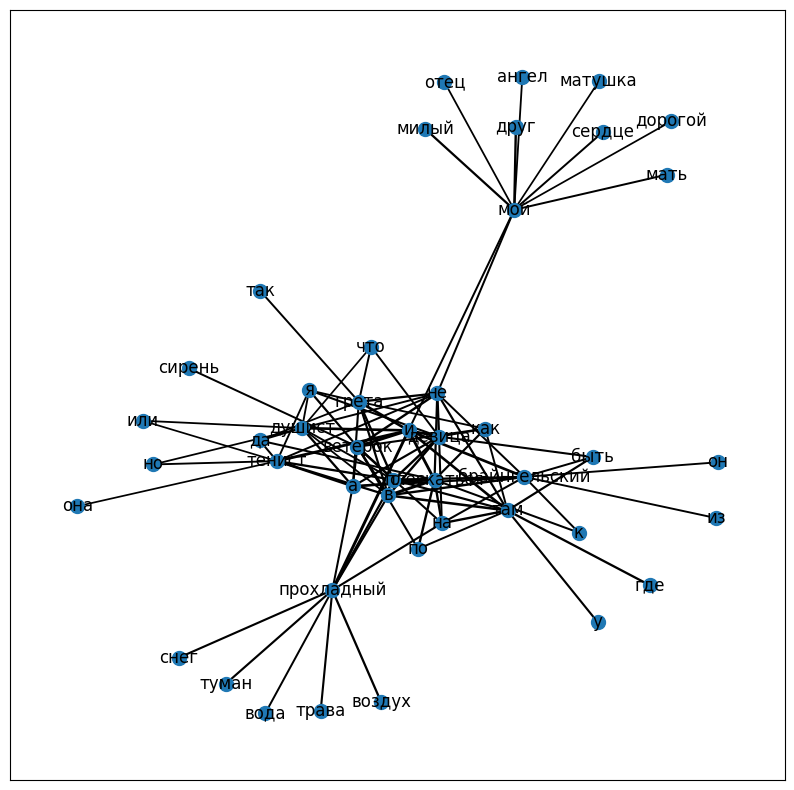

In [114]:
plt.figure(figsize=(10, 10))
graph = nx.Graph(graphs[0])
cc_nodes = list(nx.connected_components(graph))[0]
subgraph = graph.subgraph(cc_nodes)
weights = np.array(list(nx.get_edge_attributes(subgraph, 'weight').values()))
nx.draw_networkx(subgraph, node_size=100, width=weights/4)